# Markov Random Fields

The 'Markov' in Markov Random Fields (*MRF*) comes from the assumption that pixels are uniquely described by its neighboring pixels. This is our prior assumption.
In addition, we have a likelihood term which we measure directly from data: the image intensities.

Using Bayes theorem we can find the posterior from the product of the likelihood and the prior. 
In this assignment we will find the Maximum a posteriori (*MAP*) segmentation (*f*) as our binary segmentation.

Instead of using probabilites, we will use *energies* which are easier as they sum.

The posterior energy is given as: $$ E(f | \mathcal{D}) = E(\mathcal{D} | f) + E(f)$$ and the goal is to minimize this.

The likelihood energy $$E(\mathcal{D} | f)$$ is a sum of *one-clique* potentials - potentials for singel pixels. The likelihood energy is defined as: 
$$ E(\mathcal{D} | f) = \sum_{i} V_1(f_i) = \sum_{i} (\mu(f_i) - d_i)^2 $$, where $f_i$ is the label assigned to pixel $i$, $d_i$ is the intensity of pixel $i$ and $\mu(f_i)$ is the mean intensity of class $f_i$.

The prior energy $E(f)$ is a sum of *two-clique* potentials - the potentials of pairs of pixels. 
Our prior assumptions is that neighbouring pixels are from the same class. Therefore, the two-clique potential is defiend for neighbouring pixels (in the *x* and *y* direction):

 $$V_2(f_i, f_{i'}) = \beta$$ if $f_i \neq f_{i'} $ else $V_2(f_i, f_{i'}) = 0$

In other words, the configuration/segmentation $f$ recieves a penalty $\beta$ for every neighbour pairs of pixels which are not in the same class, otherwise 0.

## Imports

In [6]:
# !pip install scikit-image numpy matplotlib opencv-python scipy
# !pip install maxflow
# !pip install seaborn
# !python -m pip install tqdm

import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import maxflow

plt.style.use("seaborn")
import seaborn as sns
# sns.set()



## Data

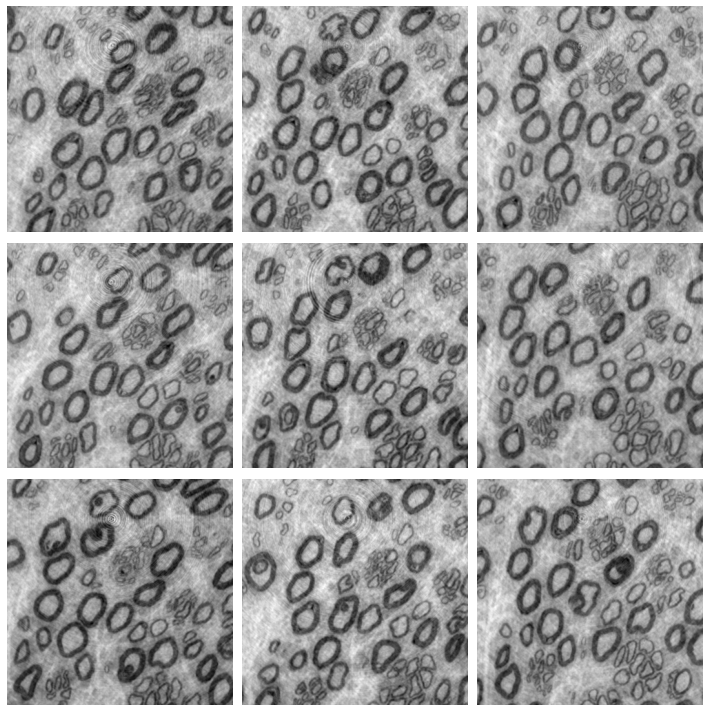

In [2]:
data_path = 'data/nerves_part.tiff'
data      = io.imread(data_path, plugin='pil') / 255.0

fig, ax = plt.subplots(3,3, figsize = (10,10))
for i in range(9):
    ax[i % 3, i // 3].imshow(data[i*100], cmap = 'gray')
    ax[i % 3, i // 3].axis('off')
fig.tight_layout()

## Pixel intesities

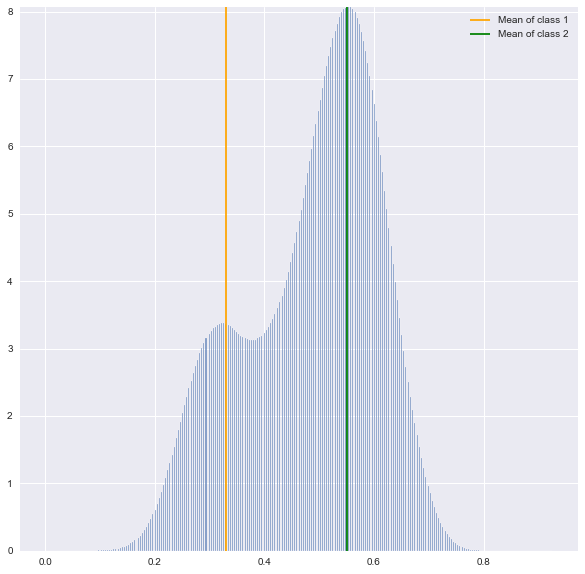

In [7]:
# Intensity histogram
mu = np.array([0.33, 0.55])

fig, ax = plt.subplots(1,1, figsize = (10,10))

n, bins, patches = ax.hist(data.ravel(), bins = 500, alpha = 0.7, density = True);
ax.vlines(x = mu[0], ymin = 0, ymax = max(n), colors = 'orange', label = 'Mean of class 1')
ax.vlines(x = mu[1], ymin = 0, ymax = max(n), colors = 'green', label = 'Mean of class 2')
ax.set_ylim(0, max(n))
ax.legend();

## Graph Cuts

The interactions modelled by MRF prior make optimization (finding an optimal configuration) of the MRF very difficult. 

For the binary segmentation task, however, with only one-clique and 2-clique potential (as in our case), the optimal configuration can be found as finding a minimum $s-t$ cut of a graph constructed from the energyfunction

Text(0.5, 1.0, 'segmentation histogram')

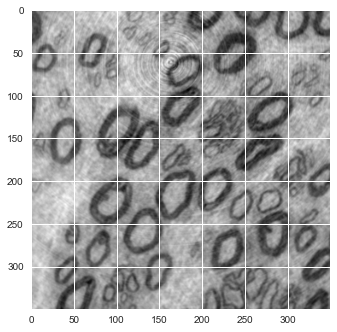

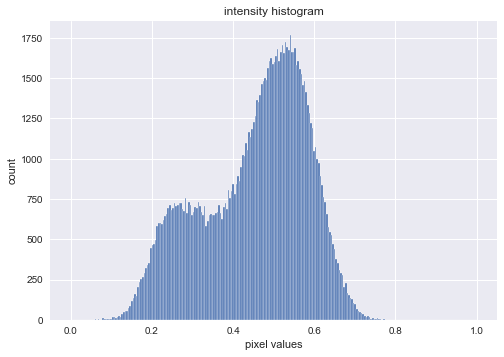

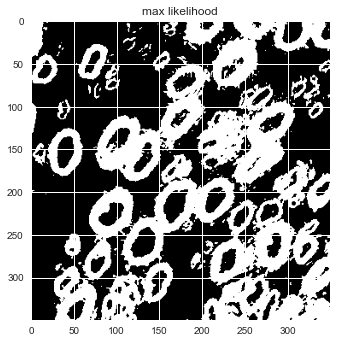

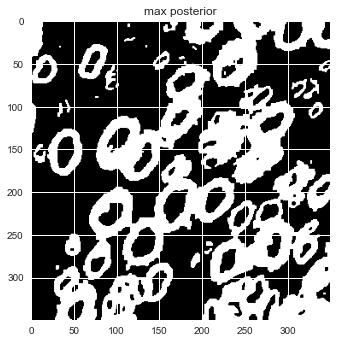

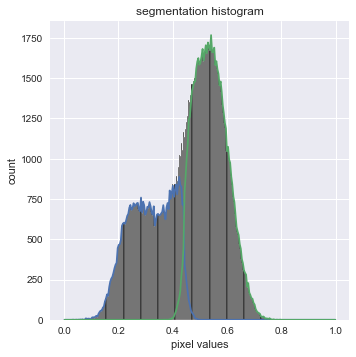

In [8]:
def segmentation_histogram(ax, I, S, edges=None):
    '''
    Histogram for data and each segmentation label.
    '''
    if edges is None:
        edges = np.linspace(I.min(), I.max(), 100)
    ax.hist(I.ravel(), bins=edges, color = 'k')
    centers = 0.5*(edges[:-1] + edges[1:]);
    for k in range(S.max()+1):
        ax.plot(centers, np.histogram(I[S==k].ravel(), edges)[0])


def MRF_segmentation(I, mu, beta):
    edges = np.linspace(0, 1, 257)
    U = np.stack([(I-mu[i])**2 for i in range(len(mu))],axis=2)
    S0 = np.argmin(U,axis=2)

    # Define prior, construct graph, solve
    # beta  = .01 #* 1e3
    g = maxflow.Graph[float]()
    nodeids = g.add_grid_nodes(I.shape)
    g.add_grid_edges(nodeids, beta)
    g.add_grid_tedges(nodeids, U[:,:,1], U[:,:,0])

    #  solving
    g.maxflow()
    S = g.get_grid_segments(nodeids)

    return edges, S, S0

I = data[0]
edges, S, S0 = MRF_segmentation(I, mu, beta = .01)

fig, ax = plt.subplots()
ax.imshow(I, cmap=plt.cm.gray)

# edges = np.linspace(0, 1, 257)
fig, ax = plt.subplots()
ax.hist(I.ravel(), edges)
ax.set_xlabel('pixel values')
ax.set_ylabel('count')
ax.set_title('intensity histogram')

#%% Define likelihood
# mu = np.array([0.40, 0.71])
# U = np.stack([(I-mu[i])**2 for i in range(len(mu))],axis=2)
# S0 = np.argmin(U,axis=2)

fig, ax = plt.subplots()
ax.imshow(S0)
ax.set_title('max likelihood')

# Define prior, construct graph, solve
# beta  = .01 #* 1e3
# g = maxflow.Graph[float]()
# nodeids = g.add_grid_nodes(I.shape)
# g.add_grid_edges(nodeids, beta)
# g.add_grid_tedges(nodeids, U[:,:,1], U[:,:,0])

#  solving
# g.maxflow()
# S = g.get_grid_segments(nodeids)

fig, ax = plt.subplots()
ax.imshow(S)
ax.set_title('max posterior')

fig, ax = plt.subplots()
segmentation_histogram(ax, I, S, edges=edges)
ax.set_aspect(1./ax.get_data_ratio())
ax.set_xlabel('pixel values')
ax.set_ylabel('count')
ax.set_title('segmentation histogram')

In [17]:
masks = np.zeros_like(data)
i = 0
for I in tqdm(data):
    edges, S, S0 = MRF_segmentation(I, mu, beta = .01)
    masks[i] = S
    assert masks[i] == S
    i += 1

np.savez('data/nerves_part_segmentation_masks.npz', masks=masks)

You should consider upgrading via the 'c:\Users\lukas\OneDrive\Dokumenter\DTU\Kurser\02506 - Advanced Image Analysis\AIA-env\Scripts\python.exe -m pip install --upgrade pip' command.


100%|██████████| 1024/1024 [01:07<00:00, 15.23it/s]


## Plot segmentation

In [9]:
# load masks
masks = np.load('data/nerves_part_segmentation_masks.npz').get("masks")
masks.shape

# set seaborn style without grid
sns.set_style("whitegrid", {'axes.grid' : False})

### Single 1D segmentation

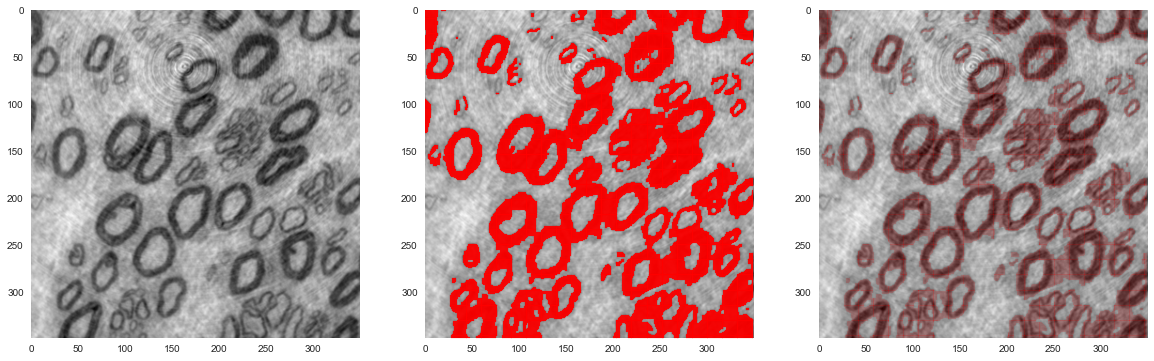

In [10]:
fig, ax = plt.subplots(1,3, figsize = (20, 20))

mask = masks[0]
ax[0].imshow(I, cmap=plt.cm.gray)
ax[0].scatter(np.where(mask==0)[1], np.where(mask == 0)[0], s = 1, c = "red", alpha=0)

ax[1].imshow(I, cmap=plt.cm.gray)
ax[1].scatter(np.where(mask==0)[1], np.where(mask == 0)[0], s = 1, c = "red", alpha=1)

ax[2].imshow(I, cmap=plt.cm.gray)
ax[2].scatter(np.where(mask==0)[1], np.where(mask == 0)[0], s = 1, c = "red", alpha=.1)

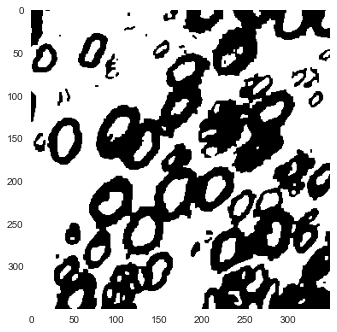

In [18]:
plt.imshow(S, cmap = "gray")
plt.savefig('data/nerves_part_segmentation_slice0.png')